In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [13]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [8]:
# reflect an existing database into a new model
# reflect the tables
Base = automap_base()

Base.prepare(engine, reflect=True)

In [9]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [10]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [11]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [14]:
# Get a list of column names and types
inspector = inspect(engine)
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [15]:
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [29]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Calculate the date 1 year ago from the last data point in the database
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
last_date

('2017-08-23')

In [35]:
# Perform a query to retrieve the data and precipitation scores
sel = [Measurement.date, Measurement.prcp]
annual_precip = session.query(*sel).\
    filter(Measurement.date <= '2017-08-23').\
    filter(Measurement.date >= '2016-08-23').\
    group_by(Measurement.date).all()
annual_precip

[('2016-08-23', 0.0),
 ('2016-08-24', 0.08),
 ('2016-08-25', 0.08),
 ('2016-08-26', 0.0),
 ('2016-08-27', 0.0),
 ('2016-08-28', 0.01),
 ('2016-08-29', 0.0),
 ('2016-08-30', 0.0),
 ('2016-08-31', 0.13),
 ('2016-09-01', 0.0),
 ('2016-09-02', 0.0),
 ('2016-09-03', 0.0),
 ('2016-09-04', 0.03),
 ('2016-09-05', None),
 ('2016-09-06', None),
 ('2016-09-07', 0.05),
 ('2016-09-08', 0.0),
 ('2016-09-09', 0.03),
 ('2016-09-10', 0.0),
 ('2016-09-11', 0.05),
 ('2016-09-12', 0.0),
 ('2016-09-13', 0.02),
 ('2016-09-14', 1.32),
 ('2016-09-15', 0.42),
 ('2016-09-16', 0.06),
 ('2016-09-17', 0.05),
 ('2016-09-18', 0.0),
 ('2016-09-19', 0.0),
 ('2016-09-20', 0.0),
 ('2016-09-21', 0.0),
 ('2016-09-22', 0.02),
 ('2016-09-23', 0.0),
 ('2016-09-24', 0.0),
 ('2016-09-25', 0.0),
 ('2016-09-26', 0.06),
 ('2016-09-27', 0.02),
 ('2016-09-28', 0.0),
 ('2016-09-29', 0.0),
 ('2016-09-30', 0.0),
 ('2016-10-01', 0.0),
 ('2016-10-02', 0.0),
 ('2016-10-03', 0.0),
 ('2016-10-04', 0.0),
 ('2016-10-05', 0.0),
 ('2016-10-06'

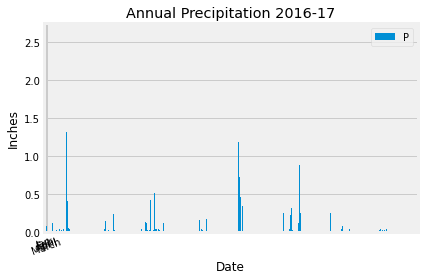

In [116]:
# Save the query results as a Pandas DataFrame and set the index to the date column
pricip_df = pd.DataFrame(annual_precip, columns=['date', 'prcp'])
pricip_df.set_index('date', inplace=True)

# Sort the dataframe by date

# Use Pandas Plotting with Matplotlib to plot the data
pricip_df.plot.bar()
plt.title('Annual Precipitation 2016-17')
plt.xlabel('Date')
plt.xticks(ticks=range(len('date')),\
           labels=['Jan', 'Feb', 'March', 'April', 'May', 'June', 'July', 'Aug',\
            'Sept', 'Oct', 'Nov', 'Dec'],\
           rotation=20)
plt.ylabel('Inches')
plt.legend('Precipitaion', loc='upper right')

plt.tight_layout()
plt.show()

In [71]:
# Use Pandas to calcualte the summary statistics for the precipitation data
summary_stats = climate_df.prcp.describe()
summary_stats

count    364.000000
mean       0.048709
std        0.204930
min        0.000000
25%        0.000000
50%        0.000000
75%        0.020000
max        2.620000
Name: prcp, dtype: float64

In [72]:
# Design a query to show how many stations are available in this dataset
session.query(Measurement.station).distinct().all()

[('USC00519397'),
 ('USC00513117'),
 ('USC00514830'),
 ('USC00517948'),
 ('USC00518838'),
 ('USC00519523'),
 ('USC00519281'),
 ('USC00511918'),
 ('USC00516128')]

In [121]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
Stations = session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.prcp).desc()).all()
Stations

[('USC00519281', 2772),
 ('USC00513117', 2709),
 ('USC00519397', 2724),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [122]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
sel = [Measurement.station, func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)]
active_stationT = session.query(*sel).\
    filter(Measurement.station == 'USC00519281')
station_df = pd.DataFrame(active_station, columns=['station', 'minT', 'maxT', 'avgT'])
station_df

,station,minT,maxT,avgT
0,USC00519281,54.0,85.0,71.663781


In [112]:
# Choose the station with the highest number of temperature observations.
StationT = session.query(Measurement.station, func.count(Measurement.tobs)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.tobs).desc()).first()
StationT

('USC00519281', 2772)

In [115]:
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
sel = [Measurement.date, Measurement.tobs]
annual_temps = session.query(*sel).\
    filter(Measurement.date <= '2017-08-23').\
    filter(Measurement.date >= '2016-08-23').\
    group_by(Measurement.date).all()
annual_temps

[('2016-08-23', 81.0),
 ('2016-08-24', 79.0),
 ('2016-08-25', 80.0),
 ('2016-08-26', 79.0),
 ('2016-08-27', 77.0),
 ('2016-08-28', 78.0),
 ('2016-08-29', 78.0),
 ('2016-08-30', 79.0),
 ('2016-08-31', 80.0),
 ('2016-09-01', 81.0),
 ('2016-09-02', 80.0),
 ('2016-09-03', 79.0),
 ('2016-09-04', 75.0),
 ('2016-09-05', 79.0),
 ('2016-09-06', 76.0),
 ('2016-09-07', 76.0),
 ('2016-09-08', 80.0),
 ('2016-09-09', 79.0),
 ('2016-09-10', 78.0),
 ('2016-09-11', 76.0),
 ('2016-09-12', 78.0),
 ('2016-09-13', 78.0),
 ('2016-09-14', 75.0),
 ('2016-09-15', 79.0),
 ('2016-09-16', 80.0),
 ('2016-09-17', 79.0),
 ('2016-09-18', 81.0),
 ('2016-09-19', 77.0),
 ('2016-09-20', 77.0),
 ('2016-09-21', 78.0),
 ('2016-09-22', 76.0),
 ('2016-09-23', 82.0),
 ('2016-09-24', 81.0),
 ('2016-09-25', 78.0),
 ('2016-09-26', 80.0),
 ('2016-09-27', 80.0),
 ('2016-09-28', 79.0),
 ('2016-09-29', 80.0),
 ('2016-09-30', 80.0),
 ('2016-10-01', 80.0),
 ('2016-10-02', 79.0),
 ('2016-10-03', 79.0),
 ('2016-10-04', 79.0),
 ('2016-10-

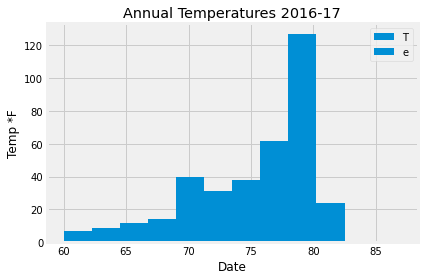

In [237]:
# Save the query results as a Pandas DataFrame and set the index to the date column
temp_df = pd.DataFrame(annual_temps, columns=['date', 'tobs'])
temp_df.set_index('date', inplace=True)
temp_df
# Sort the dataframe by date

# Use Pandas Plotting with Matplotlib to plot the data
temp_df.plot.hist(bins=12)
plt.title('Annual Temperatures 2016-17')
plt.xlabel('Date')

plt.ylabel('Temp *F')
plt.legend('Temperature', loc='upper right')

plt.tight_layout()
plt.show()

## Bonus Challenge Assignment

In [127]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [247]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
myTemp_df = pd.DataFrame(calc_temps('2017-02-22', '2017-03-2'), columns=['Tmin','Tavg','Tmax'])
myTemp_df

,Tmin,Tavg,Tmax
0,61.0,70.763975,82.0


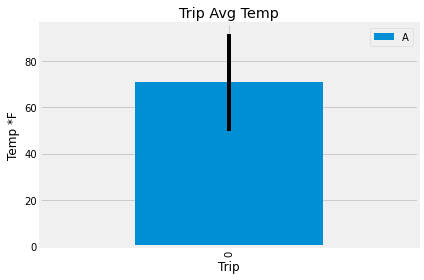

In [248]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
myTemp_df.plot.bar(y='Tavg')
plt.title('Trip Avg Temp')
plt.xlabel('Trip')
plt.ylabel('Temp *F')
plt.legend('Avg Temp', loc='upper right')
plt.errorbar(x=0, y=float(myTemp_df['Tavg']), yerr=(float(myTemp_df['Tmax']-float(myTemp_df['Tmin']))), ecolor='black')

plt.tight_layout()
plt.show()

In [249]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
# This function called `calc_pricip` will accept start date and end date in the format '%Y-%m-%d' 
# and return the total amount of rainfall per weather station for that range of dates
def calc_pricip(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    sel = [Station.station, Station.name, Station.latitude, Station.longitude, Station.elevation, func.sum(Measurement.prcp)]
    return session.query(*sel).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).\
        filter(Station.station == Measurement.station).\
        group_by(Station.station).\
        order_by(func.sum(Measurement.prcp).desc()).all()

# function usage example
print(calc_pricip('2012-02-28', '2012-03-05'))

[('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9, 11.08), ('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4, 10.32), ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 5.79), ('USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6, 3.8400000000000003), ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5, 2.92), ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 1.1800000000000002), ('USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 21.3152, -157.9992, 0.9, 0.76), ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0, 0.03), ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, 0.0)]


In [250]:
my_pricip_df = pd.DataFrame(calc_pricip('2017-02-22', '2017-03-02'), columns=['station','name','lat','lng','elev','annual prcp'])
my_pricip_df

,station,name,lat,lng,elev,annual prcp
0,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9,4.10
1,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6,3.87
2,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4,3.60
3,USC00517948,"PEARL CITY, HI US",21.39340,-157.97510,11.9,3.01
4,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5,2.20
5,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0,2.02
6,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0,1.27


In [251]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [252]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`
normals = []

# Set the start and end date of the trip
start = dt.datetime(2021, 2, 22)
end = dt.datetime(2021, 3, 2)

# Use the start and end date to create a range of dates
start.strftime("%m-%d")
end.strftime("%m-%d")
# Stip off the year and save a list of %m-%d strings
trip_dates = []
date_generated = [start + dt.timedelta(days=x) for x in range(0, (end-start).days)]

for date in date_generated:
    trip_dates.append(date.strftime("%m-%d")) #['02-22', '02-23','02-24','02-25','02-26','02-27','02-28','03-01']
# Loop through the list of %m-%d strings and calculate the normals for each date
for d in trip_dates:
    normals.append(list(np.ravel(daily_normals(d))))

normals

[[60.0, 70.15789473684211, 83.0],
 [62.0, 70.35593220338983, 81.0],
 [61.0, 68.56666666666666, 76.0],
 [61.0, 68.59649122807018, 76.0],
 [62.0, 69.89285714285714, 78.0],
 [58.0, 69.98148148148148, 77.0],
 [65.0, 70.65517241379311, 80.0],
 [64.0, 70.0327868852459, 76.0]]

In [253]:
# View the accuracy of the date_generated alrgorithm for creating trip_dates list
trip_dates

['02-22', '02-23', '02-24', '02-25', '02-26', '02-27', '02-28', '03-01']

In [254]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
normals_df = pd.DataFrame(normals, columns=['tmin', 'tavg','tmax'])
normals_df.set_index(pd.Index(trip_dates), 'date', inplace=True)
normals_df

,tmin,tavg,tmax
02-22,60.0,70.157895,83.0
02-23,62.0,70.355932,81.0
02-24,61.0,68.566667,76.0
02-25,61.0,68.596491,76.0
02-26,62.0,69.892857,78.0
02-27,58.0,69.981481,77.0
02-28,65.0,70.655172,80.0
03-01,64.0,70.032787,76.0


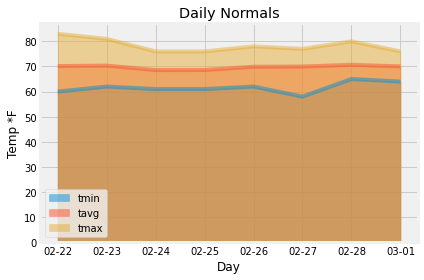

In [255]:
# Plot the daily normals as an area plot with `stacked=False`
normals_df.plot(kind='area', stacked=False)
plt.title('Daily Normals')
plt.xlabel('Day')
plt.ylabel('Temp *F')


plt.tight_layout()
plt.show()